In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import concurrent.futures
from itertools import repeat
from helper import run_simulation_complex_wrapper

In [2]:
# load data
df_edges = pd.read_csv("../data/musae_git_edges.csv")
df_nodes = pd.read_csv("../data/musae_git_target.csv")

# build graph
# create graph
G = nx.Graph()

# Add nodes to the graph
for index, row in df_nodes.iterrows():
    G.add_node(row['id'], status=row['ml_target'])

# Add edges to the graph
for index, row in df_edges.iterrows():
    G.add_edge(row['id_1'], row['id_2'])

In [3]:
if __name__ == '__main__':
    result_groups = []
    parameters = [
        (G.copy(), 0.05, False),
        (G.copy(), 0.1, False),
        (G.copy(), 0.2, False),
        (G.copy(), 0.25, False),
        (G.copy(), 0.3, False),
        (G.copy(), 0.4, False),
        (G.copy(), 0.5, False),
        (G.copy(), 0.7, False)
    ]

    with concurrent.futures.ProcessPoolExecutor() as executor:
        future_results = [executor.submit(run_simulation_complex_wrapper, args) for args in parameters]

        for future in concurrent.futures.as_completed(future_results):
            result = future.result()
            result_groups.append(result)

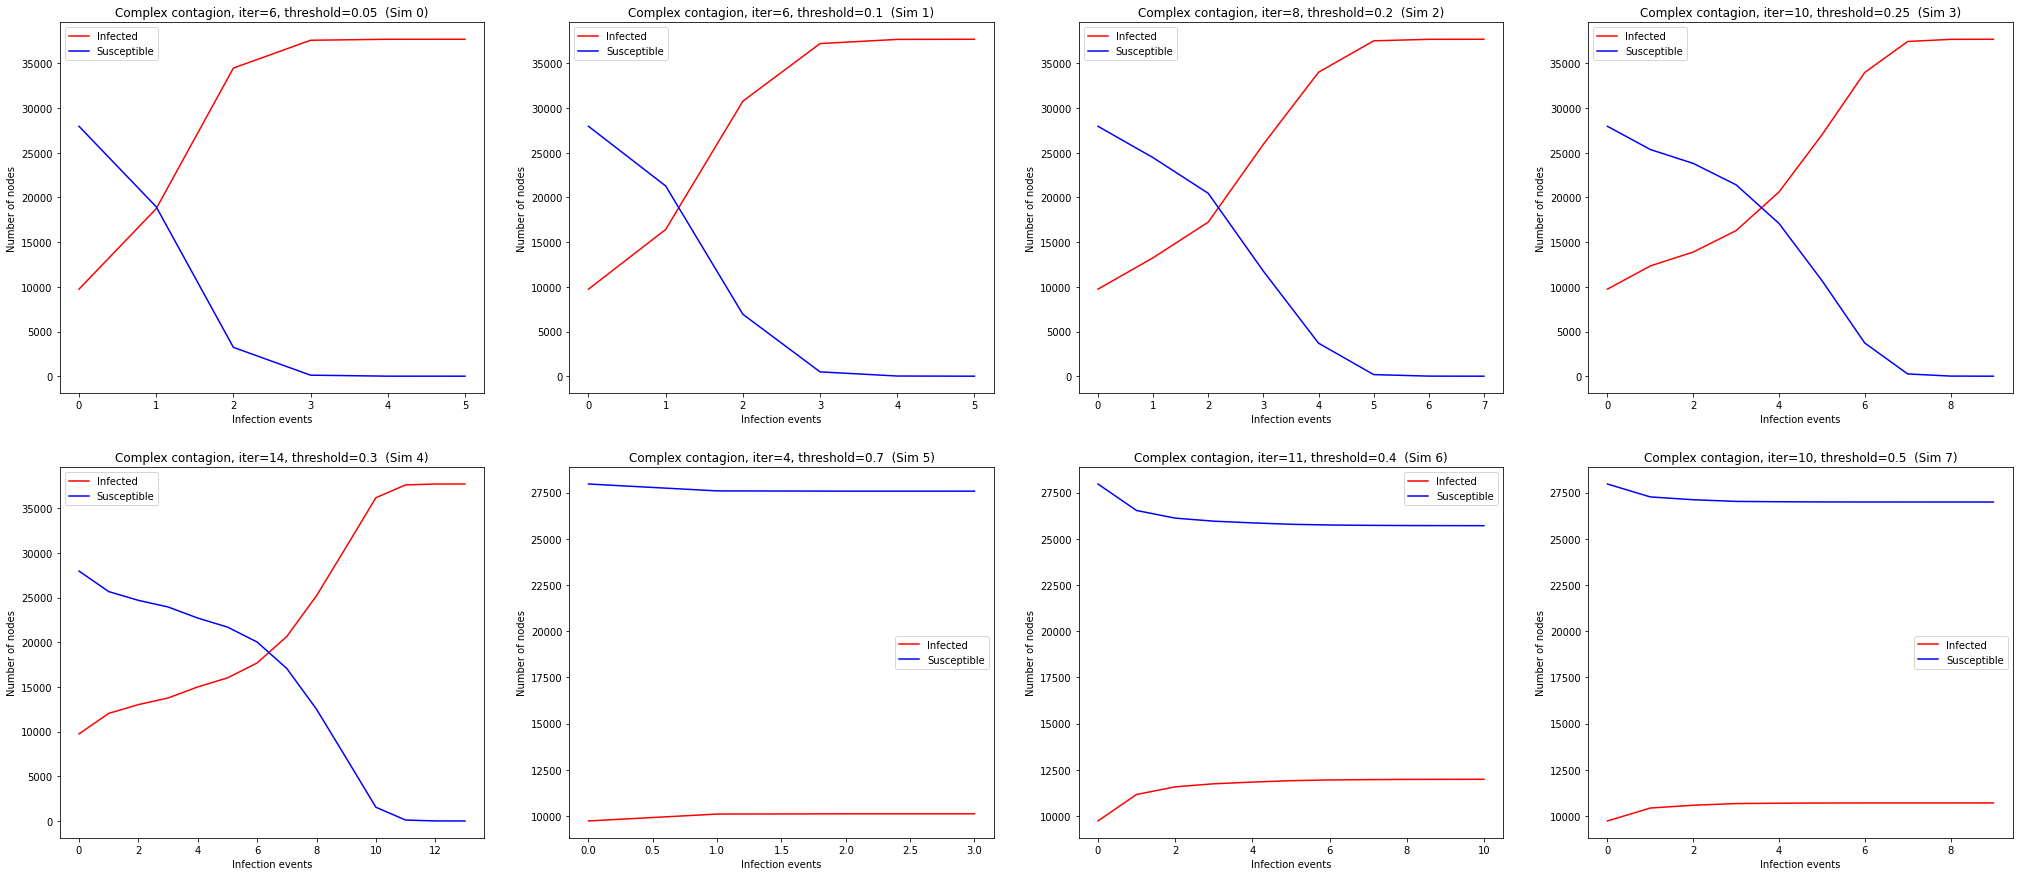

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(35, 15))
axs=axs.flatten()
i = 0

for ax, results in zip(axs, result_groups):
    x_val = range(results[3])
    title = f"Complex contagion, iter={results[3]}, threshold={results[4]}  (Sim {i})"

    ax.plot(x_val, results[1], color='red', label='Infected')
    ax.plot(x_val, results[2], color='blue', label='Susceptible')
    ax.legend()

    ax.set_xlabel("Infection events")
    ax.set_ylabel("Number of nodes")
    
    ax.set_title(title)
    i+=1

fig.savefig(f"plots/complex-contagion.jpg", bbox_inches='tight', dpi=300)
fig.savefig(f"plots/complex-contagion-smallsize.jpg", bbox_inches='tight', dpi=150)
plt.show()

In [6]:
df_list = []
for results in result_groups:
    # Get the node attributes as a dictionary
    node_dict = nx.get_node_attributes(results[0], 'status')
    influence_dict = nx.get_node_attributes(results[0], 'influence')

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame({
        'id': node_dict.keys(),
        'status': node_dict.values(),
        'influence': influence_dict.values(),
    })
    df_list.append(df)

In [7]:
# get the nodes from the graph with the most connections
sorted_influential = dict(sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True))
top_20_infl = dict(list(sorted_influential.items())[:20])
top_20_infl

{31890: 0.25088198625958247,
 27803: 0.18793601952306427,
 35773: 0.08817210005570439,
 19222: 0.07846361972466113,
 13638: 0.06546592747818245,
 36652: 0.062150189660203185,
 18163: 0.05103583649433672,
 9051: 0.04766704687126979,
 35008: 0.0416721928963633,
 10001: 0.041592615188731794,
 36628: 0.03997453513355792,
 7027: 0.039390965277593566,
 19253: 0.03724236717154301,
 2078: 0.03628743467996499,
 33671: 0.03573039072654447,
 5629: 0.03490808774768561,
 73: 0.03360831852303774,
 3712: 0.033528740815406244,
 11051: 0.03289211915435423,
 30002: 0.027984827183744926}

In [8]:
# show the nodes that have infected the most nodes and check if these also coincide with 
# the nodes with the most connections

top_ids = []
for df in df_list:
    top_infl = df.sort_values('influence', ascending=False).head()
    print(top_infl)
    print(" ")

    common_ids = set(top_infl['id'].tolist()).intersection(set(top_20_infl.keys()))
    top_ids += list(common_ids)
    print(f"Common IDs from top influential nodes and most connected nodes: {common_ids}")
    print(" ")

          id  status  influence
31890  31890       1       5599
27803  27803       1       3484
19222  19222       1       2226
13638  13638       1       1979
18163  18163       1       1300
 
Common IDs from top influential nodes and most connected nodes: {13638, 31890, 18163, 19222, 27803}
 
          id  status  influence
31890  31890       1       6497
27803  27803       1       4168
36652  36652       1       1449
18163  18163       1       1400
19222  19222       1       1335
 
Common IDs from top influential nodes and most connected nodes: {36652, 31890, 18163, 19222, 27803}
 
          id  status  influence
31890  31890       1       6396
27803  27803       1       4904
19222  19222       1       1774
13638  13638       1       1565
36652  36652       1       1426
 
Common IDs from top influential nodes and most connected nodes: {13638, 36652, 31890, 19222, 27803}
 
          id  status  influence
31890  31890       1       5392
27803  27803       1       4662
19222  19222    

In [9]:
# count the coinciding nodes and on how many simulations they appear as the most influential
counted_ids = dict(sorted(Counter(top_ids).items(), key=lambda x: x[1], reverse=True))
counted_ids

{31890: 5, 19222: 5, 27803: 5, 13638: 4, 36652: 4, 18163: 2, 33671: 1}

In [10]:
# display their initial status
df_nodes_indexed = df_nodes.set_index("id")
df_nodes_indexed.loc[list(counted_ids.keys())]

,name,ml_target
id,,
31890,dalinhuang99,0
19222,Bunlong,0
27803,nfultz,0
13638,gabrielpconceicao,0
36652,rfthusn,0
18163,nelsonic,0
33671,shayan-taheri,0
